## This Notebook is run in a Kaggle P100 notebook instance

We used U-Net with efficientnetb0 as the segmentation model.
__________

### Installing the dependencies

In [1]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=2eba0733b17032bcfba42c8ca08e0ad5696aa2aec32b5de29034c47e0e384d3c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8566432e3da681634f840f86628d9e78620239cf0bfdc1f553f60b2a431a726a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing in

### Imports

In [2]:
# to prevent certification error while downloading a backbone for training

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch.nn.functional as F
import albumentations as A
import tifffile as tiff
import torch.nn as nn
import pandas as pd
import numpy as np

import torchvision
import torch
import time
import timm
import sys
import cv2
import gc
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
from segmentation_models_pytorch.base.modules import Activation
from sklearn.metrics import average_precision_score
from segmentation_models_pytorch.utils import base
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torch.autograd import Variable
from sklearn import preprocessing
from tqdm.notebook import tqdm
from PIL import Image
from glob import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Defining variables

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu') 

In [5]:
# Define file paths for train images and masks using glob to match all files in the specified directories
IMG_PATH_TRAIN = sorted(glob('/kaggle/input/train-val-split-data/Train/Images/*'))
MASK_PATH_TRAIN = sorted(glob('/kaggle/input/train-val-split-data/Train/Masks/*'))

# Define file paths for val images and masks using glob to match all files in the specified directories
IMG_PATH_VAL = sorted(glob('/kaggle/input/train-val-split-data/Val/Images/*'))
MASK_PATH_VAL = sorted(glob('/kaggle/input/train-val-split-data/Val/Masks/*'))

In [6]:
# Configuration for Image Segmentation Model


# Model Settings

# Name of the neural network architecture to use
model_name = 'efficientnet-b0'

# List of classes or categories for segmentation
classes = ['background', 'bleeding']

# Use pre-trained weights from ImageNet for model initialization
encoder_weights = 'imagenet'

# Activation function for the final layer of the model
activation = 'sigmoid'


# Training Settings

# Number of training epochs for each fold in cross-validation
num_epochs = 100

# Early stopping: Training stops if the loss/metric does not improve for 'earlystopping' consecutive epochs
earlystopping = 10

# Batch size: Number of samples in each mini-batch during training
batch_size = 32

# Counter to keep track of epochs where loss/metric does not improve
not_improve = 0

# Variable to store the best Dice loss observed during training (initialized to infinity)
best_dice_loss = np.inf

# Lists to append epoch-wise training and validation loss/metric values
train_logs_list, valid_logs_list = [], []


# Optimizer and Scheduler Settings

# Maximum learning rate for the optimizer
max_lr = 1e-3

# Weight decay term for the AdamW optimizer
weight_decay = 1e-5

# Minimum learning rate used during training (typically for learning rate schedulers)
min_lr = 1e-6


# Metric Threshold

# Threshold value used to convert model predictions into binary masks during evaluation
threshold = 0.4

### Defining functions

In [7]:
def _threshold(x, threshold=None):
    """
    Thresholds the input tensor.

    Args:
        x (torch.Tensor): The input tensor to be thresholded.
        threshold (float or None): The threshold value. If None, no thresholding is applied.

    Returns:
        torch.Tensor: The thresholded tensor with values either 0 or 1, based on the threshold.

    Example:
        >>> x = torch.tensor([0.2, 0.6, 0.8, 0.3])
        >>> threshold = 0.5
        >>> _threshold(x, threshold)
        tensor([0., 1., 1., 0.])
    """
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


In [8]:
class SegDataset(Dataset):
    """
    A PyTorch dataset for segmentation tasks.

    Args:
        image_list (list): List of file paths to input images.
        mask_list (list): List of file paths to corresponding mask images.
        classes (list, optional): List of class labels (not used in this class).
        transform (callable, optional): A function/transform to apply to the images and masks.

    Attributes:
        image_list (list): List of file paths to input images.
        mask_list (list): List of file paths to corresponding mask images.
        classes (list): List of class labels (not used in this class).
        transform (callable): A function/transform to apply to the images and masks.

    Methods:
        __getitem__(idx): Retrieves an image and mask pair by index.
        __len__(): Returns the total number of samples in the dataset.
    """

    def __init__(self, image_list, mask_list, classes=None, transform=None):
        """
        Initializes the dataset.

        Args:
            image_list (list): List of file paths to input images.
            mask_list (list): List of file paths to corresponding mask images.
            classes (list, optional): List of class labels (not used in this class).
            transform (callable, optional): A function/transform to apply to the images and masks.
        """
        self.image_list = image_list
        self.mask_list = mask_list
        self.classes = classes
        self.transform = transform

    def __getitem__(self, idx):
        """
        Retrieves an image and mask pair by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and mask as PyTorch tensors.
        """
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]

        # Load and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype('uint8')

        # Load the mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.stack((mask,) * 3, axis=-1)
        mask = mask[:, :, 0]

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float() / 255
            mask = mask.long().unsqueeze(0)
        else:
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float() / 255
            mask = mask.float() / 255
            mask = mask.long().unsqueeze(0)
        return image, mask.float()

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.image_list)

In [9]:
def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """

    pr = _threshold(pr, threshold=threshold)
    # pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score

In [10]:
# Alias for the base Metric class from the segmentation models library.
# Used for defining custom metrics.
smp_met = base.Metric

# Alias for the base Loss class from the segmentation models library.
# Used for defining custom loss functions.
smp_loss = base.Loss

# Alias for the Activation class from the segmentation models library.
# Used for defining custom activation functions.
smp_act = Activation

# Alias for the precision function defined above.
# Used for calculating precision scores.
smp_precision = precision

In [11]:
class MAPCoeff(smp_met):
    """
    Custom metric class for Mean Average Precision (MAP) score in binary segmentation tasks.

    Args:
        eps (float, optional): A small epsilon value to prevent division by zero.
        threshold (float, optional): Threshold for binarizing the prediction output.
        activation (str or callable, optional): Activation function to be applied to the predictions.
        ignore_channels (list of int, optional): List of channels to be ignored during metric calculation.
        **kwargs: Additional keyword arguments for the base Metric class.

    Attributes:
        __name__ (str): Name of the metric ('map_score').

    Methods:
        forward(y_pr, y_gt): Calculate the Mean Average Precision score.

    """

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = smp_act(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        """
        Calculate the Mean Average Precision (MAP) score between predicted and ground truth tensors.

        Args:
            y_pr (torch.Tensor): Predicted tensor.
            y_gt (torch.Tensor): Ground truth tensor.

        Returns:
            float: The Mean Average Precision score.
        """
        y_pr = self.activation(y_pr)
        return smp_precision(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


### Create training and validation datasets using SegDataset

In [12]:
train_dataset = SegDataset(
    IMG_PATH_TRAIN,  # List of training image file paths
    MASK_PATH_TRAIN,   # List of corresponding training mask file paths
    transform=None      # Transformation function (you can specify data augmentation here)
)

val_dataset = SegDataset(
    IMG_PATH_VAL,    # List of validation image file paths
    MASK_PATH_VAL,     # List of corresponding validation mask file paths
    transform=None      # Transformation function for validation (if different from training)
)

In [13]:
print("Number of Training Samples: " + str(len(train_dataset)))
print("Number of Val Samples: " + str(len(val_dataset)))

Number of Training Samples: 1047
Number of Val Samples: 262


In [14]:
# Create DataLoader for training dataset
trainDL = torch.utils.data.DataLoader(
    train_dataset,          # Training dataset
    batch_size=16,          # Batch size for each iteration
    shuffle=True,           # Shuffle the dataset at the beginning of each epoch
    sampler=None,           # (Optional) Sampler for dataset shuffling
    batch_sampler=None,     # (Optional) BatchSampler for specifying batch sampling strategy
    num_workers=0,          # Number of subprocesses for data loading
    collate_fn=None,        # (Optional) Custom function to collate batches
    pin_memory=False,       # Whether to pin memory for faster data transfer to GPU
    drop_last=False,        # Drop the last incomplete batch if it's smaller than batch_size
    timeout=0,              # (Optional) Timeout for data loading workers
    worker_init_fn=None     # (Optional) Custom function for worker initialization
)

# Create DataLoader for validation dataset
valDL = torch.utils.data.DataLoader(
    val_dataset,            # Validation dataset
    batch_size=16,          # Batch size for each iteration
    shuffle=True,           # Shuffle the dataset at the beginning of each epoch
    sampler=None,           # (Optional) Sampler for dataset shuffling
    batch_sampler=None,     # (Optional) BatchSampler for specifying batch sampling strategy
    num_workers=0,          # Number of subprocesses for data loading
    collate_fn=None,        # (Optional) Custom function to collate batches
    pin_memory=False,       # Whether to pin memory for faster data transfer to GPU
    drop_last=False,        # Drop the last incomplete batch if it's smaller than batch_size
    timeout=0,              # (Optional) Timeout for data loading workers
    worker_init_fn=None     # (Optional) Custom function for worker initialization
)


### Visualise train and validation data

In [15]:
# Retrieve a batch of data from the training DataLoader
batch = next(iter(trainDL))

# Separate the batch into images and labels
images, labels = batch

# Print information about the batch
print("Image shape:", images.shape)
print("Label shape:", labels.shape)
print("Image data type:", type(images))
print("Label data type:", type(labels))
print("Image dtype:", images.dtype)
print("Label dtype:", labels.dtype)

Image shape: torch.Size([16, 3, 224, 224])
Label shape: torch.Size([16, 1, 224, 224])
Image data type: <class 'torch.Tensor'>
Label data type: <class 'torch.Tensor'>
Image dtype: torch.float32
Label dtype: torch.float32


In [16]:
# Select the first image and mask from the batch for testing
testImg = images[0]
testMsk = labels[0]

# Print information about the selected image and mask
print("Image shape:", testImg.shape)
print("Image data type:", testImg.dtype)
print("Image type:", type(testImg))
print("Mask shape:", testMsk.shape)
print("Mask data type:", testMsk.dtype)
print("Mask type:", type(testMsk))
print("Minimum pixel value in the image:", testImg.min())
print("Maximum pixel value in the image:", testImg.max())
print("Minimum pixel value in the mask:", testMsk.min())
print("Maximum pixel value in the mask:", testMsk.max())

Image shape: torch.Size([3, 224, 224])
Image data type: torch.float32
Image type: <class 'torch.Tensor'>
Mask shape: torch.Size([1, 224, 224])
Mask data type: torch.float32
Mask type: <class 'torch.Tensor'>
Minimum pixel value in the image: tensor(0.)
Maximum pixel value in the image: tensor(1.)
Minimum pixel value in the mask: tensor(0.)
Maximum pixel value in the mask: tensor(1.)


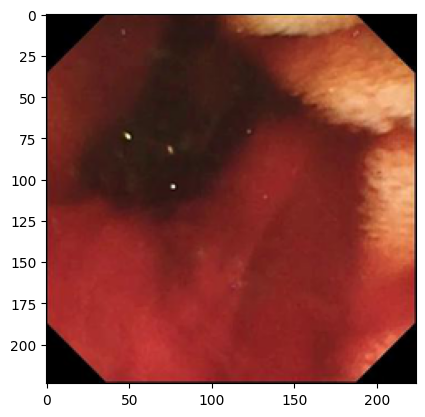

In [17]:
# Display the selected image using Matplotlib
plt.imshow(testImg.permute(1, 2, 0))
plt.show()

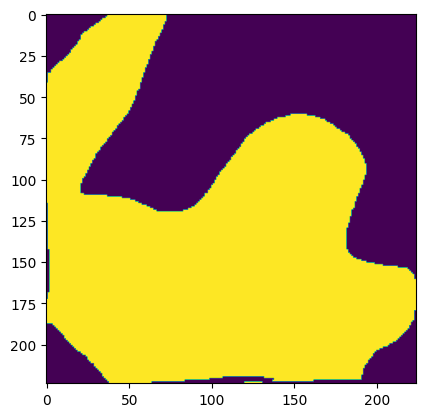

In [18]:
# Display the selected mask image using Matplotlib
plt.imshow(testMsk.permute(1, 2, 0))
plt.show()

In [19]:
# Get a batch from the validation data loader
batch = next(iter(valDL))

# Extract images and labels from the batch
images, labels = batch

# Print the shape and data types of the images and labels
print("Image shape:", images.shape)
print("Label shape:", labels.shape)
print("Image data type:", type(images))
print("Label data type:", type(labels))
print("Image dtype:", images.dtype)
print("Label dtype:", labels.dtype)

Image shape: torch.Size([16, 3, 224, 224])
Label shape: torch.Size([16, 1, 224, 224])
Image data type: <class 'torch.Tensor'>
Label data type: <class 'torch.Tensor'>
Image dtype: torch.float32
Label dtype: torch.float32


In [20]:
# Get the first image and mask from the batch
testImg = images[0]
testMsk = labels[0]

# Print information about the image and mask
print("Image shape:", testImg.shape)
print("Image data type:", testImg.dtype)
print("Image object type:", type(testImg))
print("Mask shape:", testMsk.shape)
print("Mask data type:", testMsk.dtype)
print("Mask object type:", type(testMsk))
print("Min pixel value in image:", testImg.min())
print("Max pixel value in image:", testImg.max())
print("Min pixel value in mask:", testMsk.min())
print("Max pixel value in mask:", testMsk.max())

Image shape: torch.Size([3, 224, 224])
Image data type: torch.float32
Image object type: <class 'torch.Tensor'>
Mask shape: torch.Size([1, 224, 224])
Mask data type: torch.float32
Mask object type: <class 'torch.Tensor'>
Min pixel value in image: tensor(0.)
Max pixel value in image: tensor(1.)
Min pixel value in mask: tensor(0.)
Max pixel value in mask: tensor(1.)


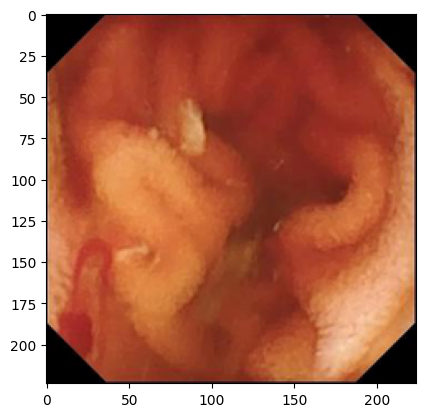

In [21]:
# Display the first image from the validation dataset
plt.imshow(testImg.permute(1, 2, 0))
plt.show()

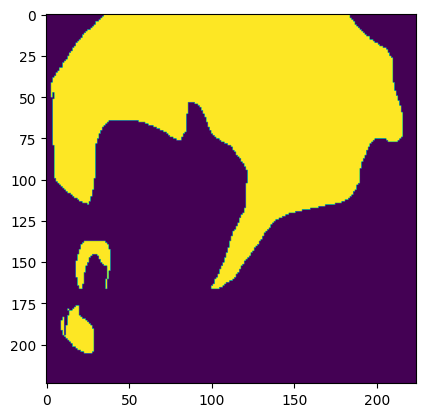

In [22]:
# Display the first mask (label) from the validation dataset
plt.imshow(testMsk.permute(1, 2, 0))
plt.show()

### Define the segmentation model 

In [23]:
model = smp.Unet(
    encoder_name=model_name,  # Specify the encoder architecture
    encoder_weights=encoder_weights,  # Use pre-trained weights if available
    classes=1,  # Number of classes 
    activation=activation,  # Activation function for the output
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 93.2MB/s]


In [24]:
# Define Binary Cross-Entropy (BCE) Loss
loss1 = smp.utils.losses.BCELoss()

# Define a list of metrics for evaluation
metrics = [
    smp.utils.metrics.IoU(threshold=threshold),         # IoU (Intersection over Union)
    smp.utils.metrics.Precision(threshold=threshold),   # Precision
    MAPCoeff(threshold=threshold)                       # Mean Average Precision (Custom metric)
]

# Define the AdamW optimizer for model training
optimizer = torch.optim.AdamW(
    model.parameters(),        # Model parameters to optimize
    lr=max_lr,                 # Learning rate
    weight_decay=weight_decay  # Weight decay (L2 regularization)
)

In [25]:
# Create a training epoch instance to train the model
train_epoch = TrainEpoch(
    model, 
    metrics = metrics,  
    loss = loss1,
    optimizer = optimizer,
    device = device,
    verbose = True,
    )

# Create a validation epoch instance to evaluate the model
valid_epoch = ValidEpoch(
    model, 
    loss = loss1,
    metrics = metrics,
    device = device,
    verbose = True,
    )

### Training loop

In [26]:
# Training loop that iterates for 'num_epochs' epochs
for i in range(0, num_epochs):
    print('Epoch: ', i+1)
    
    # Run a training epoch and get training logs
    train_logs = train_epoch.run(trainDL)
    
    # Run a validation epoch and get validation logs
    valid_logs = valid_epoch.run(valDL)
    
    # Append training and validation logs to respective lists
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)
    
    # Check if the current validation BCE loss is better than the best seen so far
    if best_dice_loss > valid_logs['bce_loss']:
        not_improve = 0
        best_dice_loss = valid_logs['bce_loss']
        
        # Save the model checkpoint
        torch.save(model, 'checkpoint_1_{}.pth'.format(model_name))
        print('Model saved!')
        
    # If the validation loss does not improve, increment the 'not_improve' counter
    elif best_dice_loss < valid_logs['bce_loss']:
        not_improve += 1
        print(f'Loss did not decrease for {not_improve} epoch')
        
        # If 'not_improve' exceeds 'earlystopping', stop training
        if not_improve >= earlystopping:
            print(f'Stop Training.')
            break
        else:
            pass
    else:
        pass
    
    # Clear GPU memory
    torch.cuda.empty_cache()
    gc.collect()

# Create DataFrames from the training and validation logs
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

Epoch:  1
valid: 100%|██████████| 17/17 [00:03<00:00,  5.13it/s, bce_loss - 0.3524, iou_score - 0.2683, precision - 0.8533, map_coeff - 0.8533]
Model saved!
Epoch:  2
valid: 100%|██████████| 17/17 [00:02<00:00,  8.50it/s, bce_loss - 0.4657, iou_score - 0.1714, precision - 0.8327, map_coeff - 0.8327]
Loss did not decrease for 1 epoch
Epoch:  3
valid: 100%|██████████| 17/17 [00:01<00:00,  9.68it/s, bce_loss - 0.5782, iou_score - 0.2776, precision - 0.6717, map_coeff - 0.6717]
Loss did not decrease for 2 epoch
Epoch:  4
valid: 100%|██████████| 17/17 [00:01<00:00,  9.20it/s, bce_loss - 0.2587, iou_score - 0.5713, precision - 0.7672, map_coeff - 0.7672]
Model saved!
Epoch:  5
valid: 100%|██████████| 17/17 [00:01<00:00,  8.98it/s, bce_loss - 0.2384, iou_score - 0.5744, precision - 0.7677, map_coeff - 0.7677]
Model saved!
Epoch:  6
valid: 100%|██████████| 17/17 [00:01<00:00,  9.72it/s, bce_loss - 0.1927, iou_score - 0.6594, precision - 0.7493, map_coeff - 0.7493]
Model saved!
Epoch:  7
valid:

### Logs 

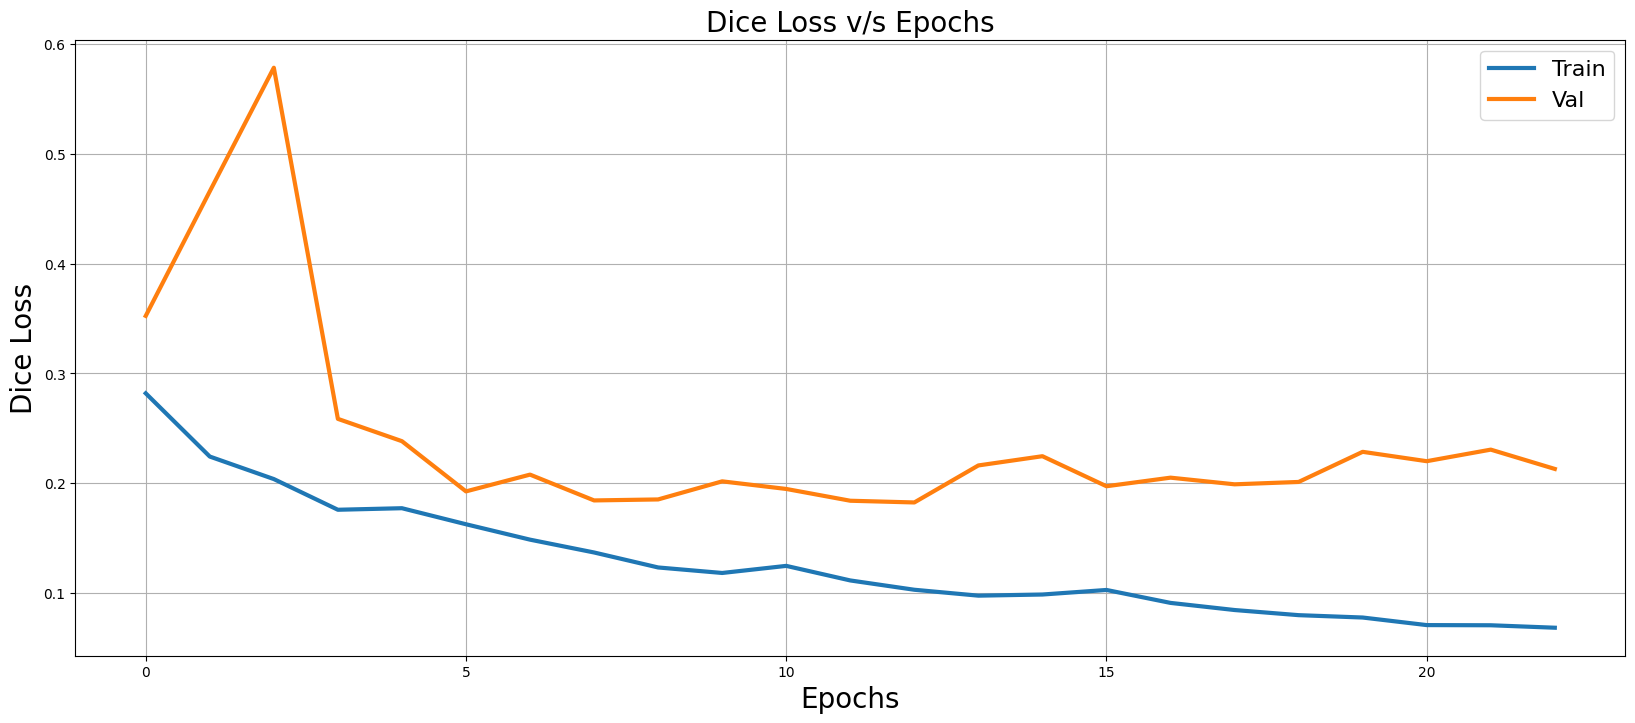

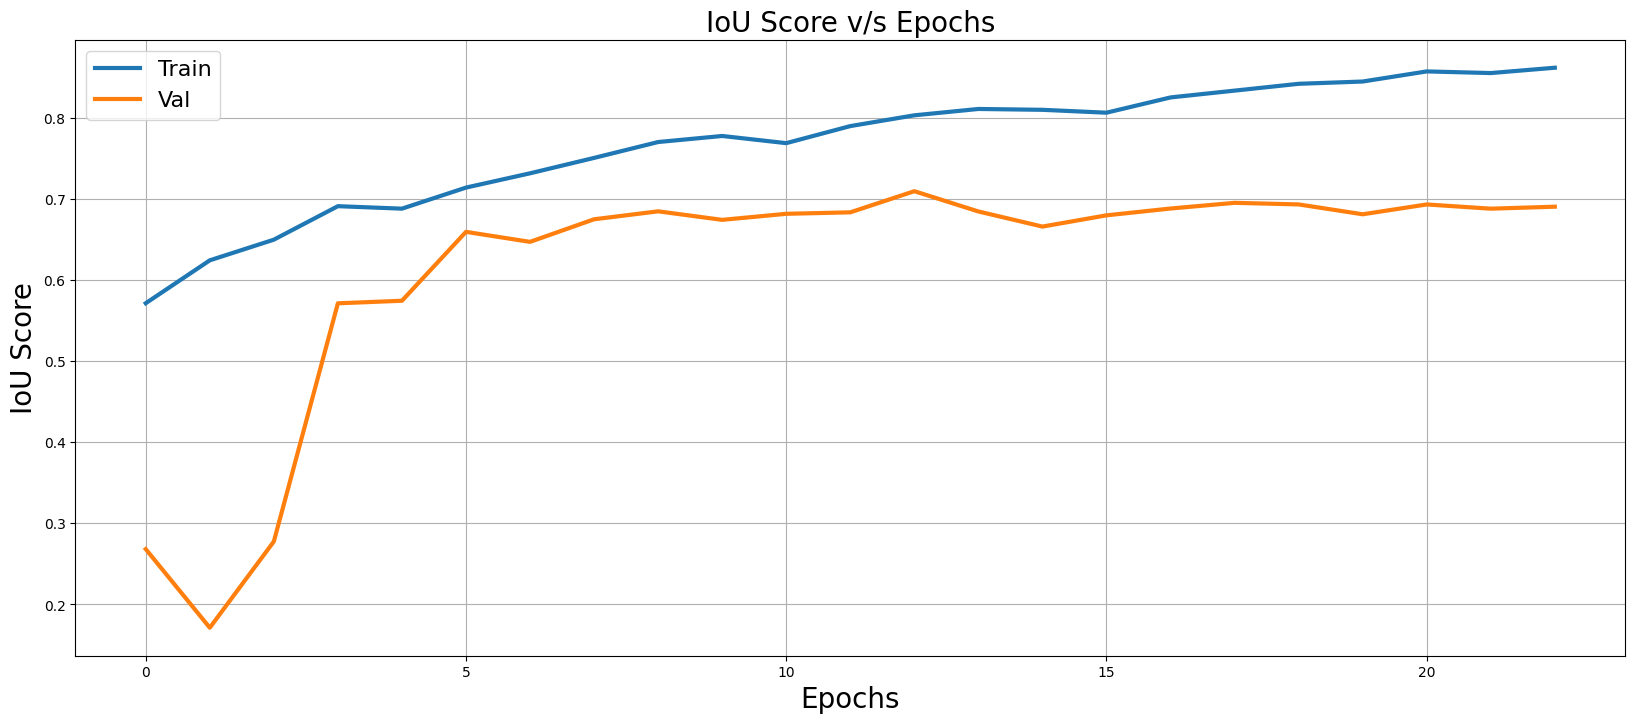

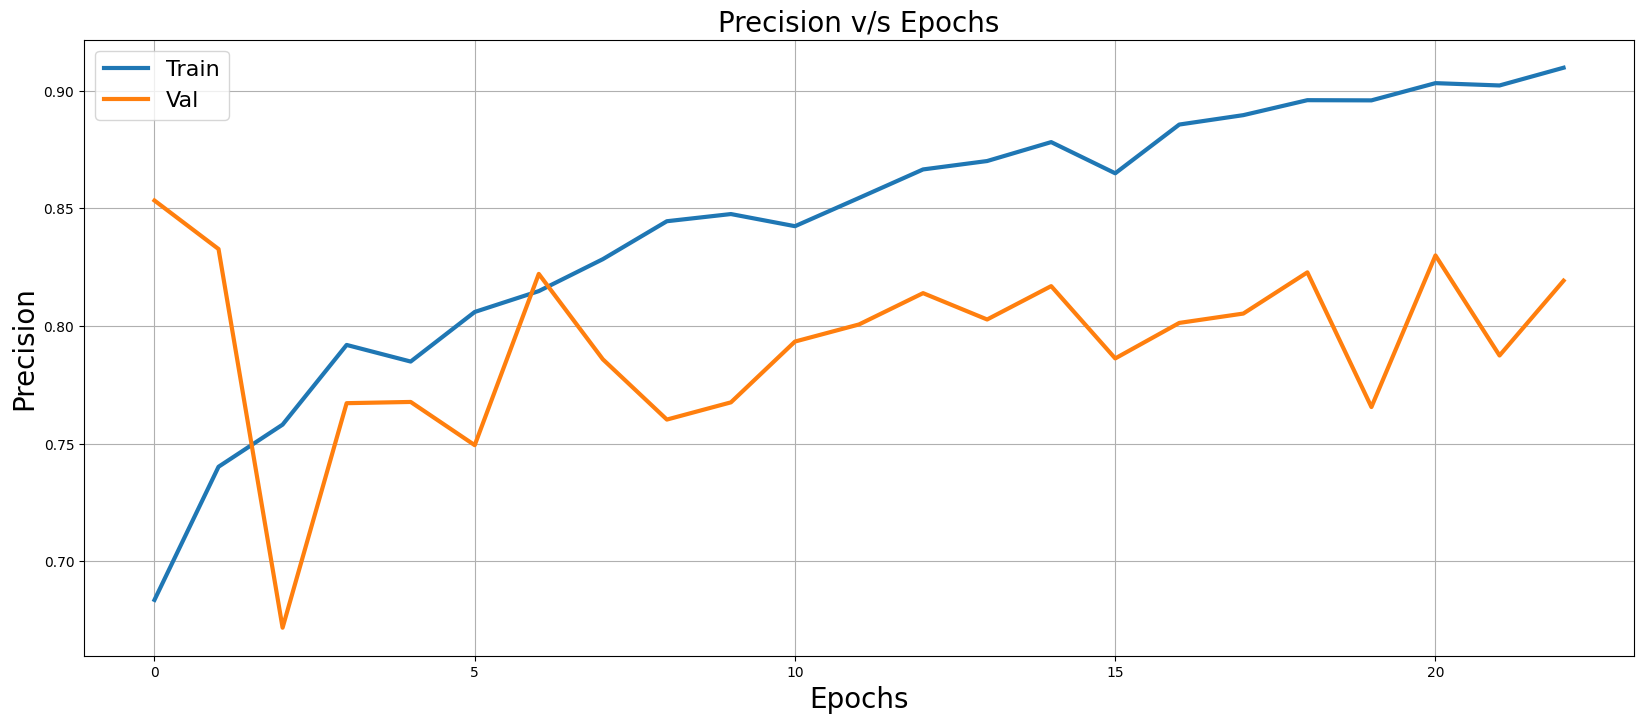

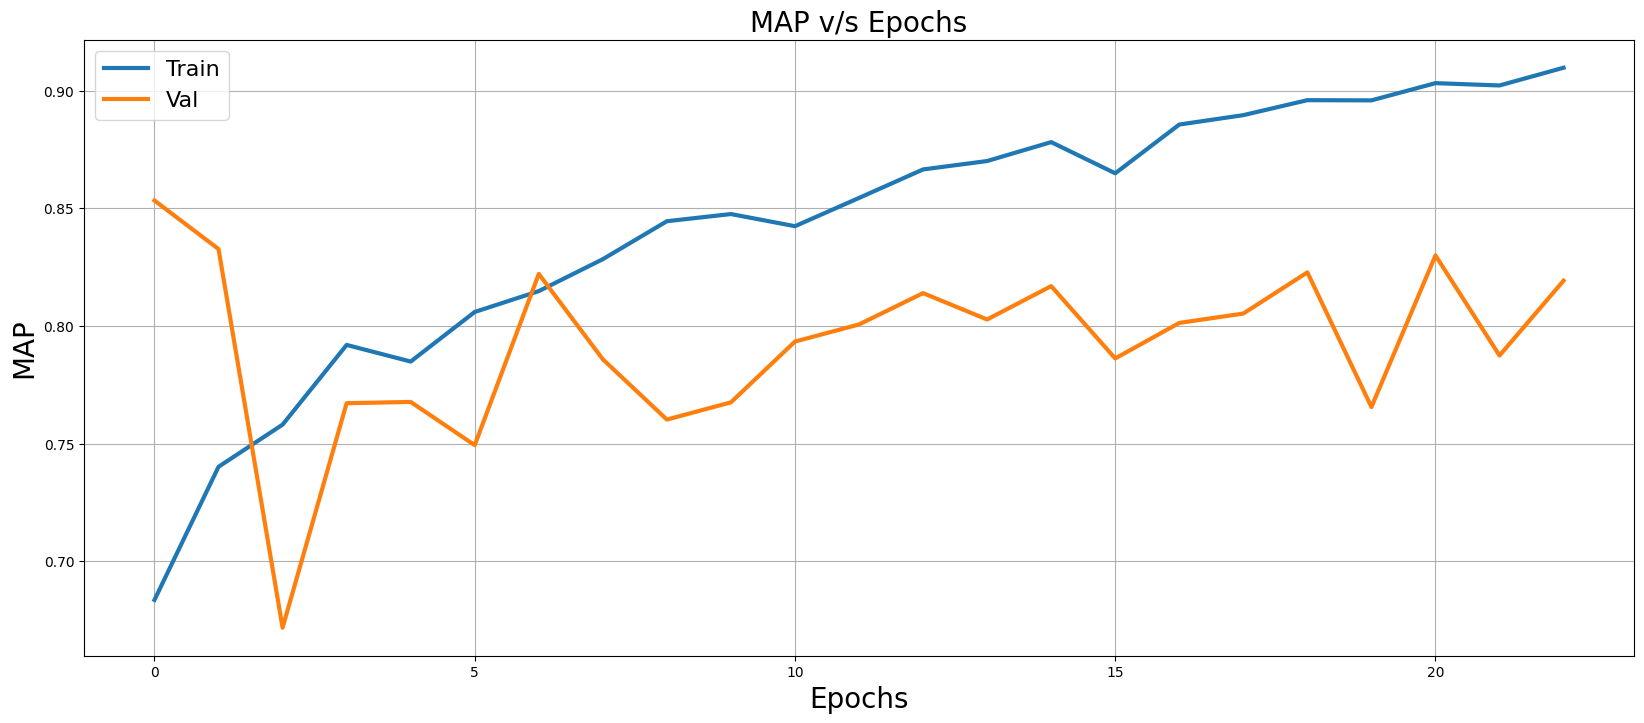

In [27]:
# Plotting the training and validation Dice Loss
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.bce_loss.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.bce_loss.tolist(), lw=3, label='Val')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss v/s Epochs', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(f'Dice_Loss_1_{model_name}.png')
plt.show()

# Plotting the training and validation IoU Score
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label='Val')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score v/s Epochs', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(f'IoU_Score_1_{model_name}.png')
plt.show()

# Plotting the training and validation Precision
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.precision.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.precision.tolist(), lw=3, label='Val')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision v/s Epochs', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(f'Precision_1_{model_name}.png')
plt.show()

# Plotting the training and validation MAP
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.map_coeff.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.map_coeff.tolist(), lw=3, label='Val')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('MAP', fontsize=20)
plt.title('MAP v/s Epochs', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(f'MAP_1_{model_name}.png')
plt.show()

In [28]:
train_logs_df['epoch'] = range(1, len(train_logs_df) + 1)
train_logs_df = train_logs_df[['epoch'] + [col for col in train_logs_df if col != 'epoch']]
train_logs_df

,epoch,bce_loss,iou_score,precision,map_coeff
0,1,0.281940,0.571384,0.683544,0.683544
1,2,0.224396,0.624261,0.740135,0.740135
2,3,0.203906,0.649724,0.758043,0.758043
3,4,0.175980,0.691024,0.791915,0.791915
4,5,0.177388,0.687959,0.784857,0.784857
5,6,0.162797,0.713933,0.805933,0.805933
6,7,0.148776,0.731539,0.814794,0.814794
7,8,0.137110,0.750524,0.828369,0.828369
8,9,0.123476,0.770097,0.844496,0.844496
9,10,0.118465,0.777560,0.847548,0.847548


In [29]:
valid_logs_df['epoch'] = range(1, len(valid_logs_df) + 1)
valid_logs_df = valid_logs_df[['epoch'] + [col for col in valid_logs_df if col != 'epoch']]
valid_logs_df

,epoch,bce_loss,iou_score,precision,map_coeff
0,1,0.352357,0.268282,0.853297,0.853297
1,2,0.465716,0.171371,0.832674,0.832674
2,3,0.578182,0.277641,0.671724,0.671724
3,4,0.258685,0.571280,0.767163,0.767163
4,5,0.238372,0.574427,0.767686,0.767686
5,6,0.192700,0.659353,0.749316,0.749316
6,7,0.207956,0.647030,0.822109,0.822109
7,8,0.184469,0.674869,0.785817,0.785817
8,9,0.185372,0.684676,0.760196,0.760196
9,10,0.201832,0.674150,0.767516,0.767516


In [30]:
train_logs_df.to_csv('train_logs_df.csv', index=False)
valid_logs_df.to_csv('valid_logs_df.csv', index=False)

________